In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from matplotlib import rc
from matplotlib import pyplot as plt
from PyFin.api import makeSchedule
from alphamind.api import *
from alphamind.analysis.quantileanalysis import er_quantile_analysis

rc('font', **{'family': 'Microsoft YaHei', 'size': 10})
rc('mathtext', **{'default': 'regular'})
rc('legend', **{'frameon': False})

## 1. 数据准备
------------------

* 股票池：中证800
* 因子：`ETOP`
* 调仓频率：5个交易日
* 起始日：2010年1月1日
* 终止日：2019年1月31日
* 分位数：5

In [4]:
engine = SqlEngine(os.environ['DB_URI'])
universe = Universe('hs300')
factor = 'EMA5D'
freq = '10b'
start_date = '2020-01-01'
end_date = '2020-02-21'
n_bins = 5
neutralized_styles = industry_styles # risk_styles + industry_styles

dates = makeSchedule(start_date, end_date, freq, 'china.sse')
horizon = map_freq(freq)

In [5]:
%%time
factor_data = engine.fetch_factor_range(universe, factor, dates=dates)
risk_cov, risk_factors = engine.fetch_risk_model_range(universe, dates=dates)
return_data = engine.fetch_dx_return_range(universe, dates=dates, horizon=horizon)
total_data = pd.merge(factor_data, risk_factors, on=['trade_date', 'code'])
total_data = pd.merge(total_data, return_data, on=['trade_date', 'code']).dropna()

Wall time: 1.61 s


## 2. 分位数群组收益比较
-----------------------

In [7]:
neutralized_factors = neutralize(total_data[neutralized_styles].values.astype(float),
                                 total_data['EMA5D'].values,
                                 groups=total_data['trade_date'])
total_data['neutralized_factors'] = neutralized_factors

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([253], dtype='int64'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [8]:
%%time

df = pd.DataFrame(columns=['q' + str(i) for i in range(1, n_bins+1)])

grouped = total_data.groupby('trade_date')
for k, g in grouped:
    er = g['neutralized_factors'].values
    dx_return = g['dx'].values
    res = er_quantile_analysis(er, n_bins=n_bins, dx_return=dx_return, de_trend=True)
    df.loc[k, :] = res

KeyError: 'neutralized_factors'

In [9]:
df.cumsum().plot(figsize=(14, 7))

TypeError: no numeric data to plot

In [ ]:
ret_yearly = df.groupby(df.index.year).sum()
ret_yearly.plot(kind='bar', figsize=(14, 7))

<AxesSubplot:>

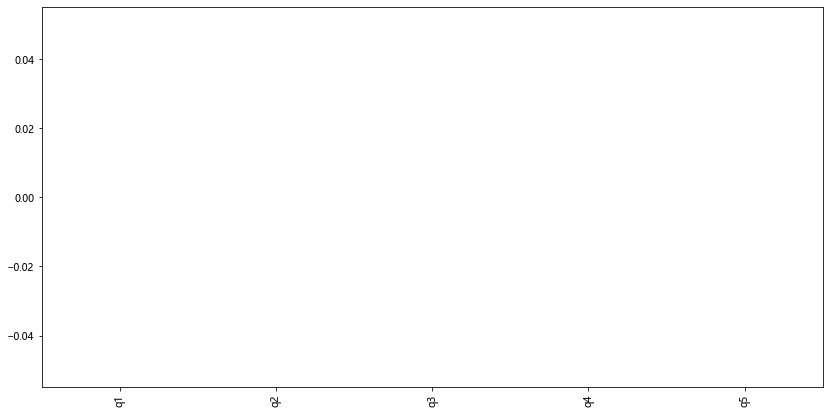

In [10]:
(df.mean() * 50).plot(kind='bar', figsize=(14, 7), color='orange')